In [14]:
import time
import sys
import numpy as np
import scipy.io
import scipy.sparse
import matplotlib.pyplot as plt

In [ ]:
mat_data = scipy.io.loadmat("mc2depi.mat")

print(f"Variables found in file: {mat_data.keys()}")

sparse_csr = mat_data['Problem']['A'][0, 0]

print("Matrix loaded successfully!")
print(f"Format: {type(sparse_csr)}")
print(f"Shape: {sparse_csr.shape}")
print(f"Non-zero elements: {sparse_csr.nnz}")


Variables found in file: dict_keys(['__header__', '__version__', '__globals__', 'Problem'])

Matrix loaded successfully!
Format: <class 'scipy.sparse._csc.csc_array'>
Shape: (525825, 525825)
Non-zero elements: 2100225


In [ ]:
def mem_usage(matrix):
    """Estimates the memory usage of a Python list of lists."""
    size = sys.getsizeof(matrix)
    for row in matrix:
        size += sys.getsizeof(row)
        for item in row:
            size += sys.getsizeof(item)
    return size


In [ ]:
def basic_multiply(A, B):
    """Performs matrix multiplication on Python lists of lists."""
    rows_A, cols_A = len(A), len(A[0])
    _, cols_B = len(B), len(B[0])
    
    C = [[0 for _ in range(cols_B)] for _ in range(rows_A)]
    
    for i in range(rows_A):
        for j in range(cols_B):
            for k in range(cols_A):
                C[i][j] += A[i][k] * B[k][j]
    return C


In [ ]:
print("Test on Basic Multiplication, Pure Python:")

py_size = 128
list_A = np.random.rand(py_size, py_size).tolist()
list_B = np.random.rand(py_size, py_size).tolist()

start_time = time.perf_counter()
_ = basic_multiply(list_A, list_B)
end_time = time.perf_counter()

mem_bytes = mem_usage(list_A)

print("--- Basic Approach (Pure Python) ---")
print(f"Size: {py_size}x{py_size}")
print(f"Execution Time: {end_time - start_time:.4f} seconds")
print(f"Memory Usage (A): {mem_bytes / 1e6:.2f} MB\n")


Test on Basic Multiplication, Pure Python:
--- Basic Approach (Pure Python) ---
Size: 128x128
Execution Time: 0.3486 seconds
Memory Usage (A): 0.53 MB



In [ ]:
print("Test on Performance vs. Matrix Size (99% Sparsity)")

matrix_sizes = [256, 512, 1024, 2048, 4096]
numpy_times = []
numpy_memory = []
scipy_times = []
scipy_memory = []

for size in matrix_sizes:

    dense_A = np.random.rand(size, size)
    dense_B = np.random.rand(size, size)
    
    start_time = time.perf_counter()
    _ = dense_A @ dense_B
    end_time = time.perf_counter()
    
    numpy_times.append(end_time - start_time)
    numpy_memory.append(dense_A.nbytes)
    
    print(f"--- Dense Matrix (NumPy) ---")
    print(f"Size: {size}x{size}")
    print(f"Execution Time: {numpy_times[-1]:.4f} seconds")
    print(f"Memory Usage (A): {numpy_memory[-1] / 1e6:.2f} MB")

    sparse_A = scipy.sparse.random(size, size, density=0.01, format='csr')
    sparse_B = scipy.sparse.random(size, size, density=0.01, format='csr')

    start_time = time.perf_counter()
    _ = sparse_A @ sparse_B
    end_time = time.perf_counter()
    
    scipy_times.append(end_time - start_time)
    mem_bytes = sparse_A.data.nbytes + sparse_A.indices.nbytes + sparse_A.indptr.nbytes
    scipy_memory.append(mem_bytes)

    print(f"--- Sparse Matrix (SciPy) ---")
    print(f"Size: {size}x{size}, Sparsity: 99%")
    print(f"Execution Time: {scipy_times[-1]:.4f} seconds")
    print(f"Memory Usage (A): {scipy_memory[-1] / 1e6:.2f} MB")


Test on Performance vs. Matrix Size (99% Sparsity)
--- Dense Matrix (NumPy) ---
Size: 256x256
Execution Time: 0.0293 seconds
Memory Usage (A): 0.52 MB
--- Sparse Matrix (SciPy) ---
Size: 256x256, Sparsity: 99%
Execution Time: 0.0002 seconds
Memory Usage (A): 0.01 MB
--- Dense Matrix (NumPy) ---
Size: 512x512
Execution Time: 0.0022 seconds
Memory Usage (A): 2.10 MB
--- Sparse Matrix (SciPy) ---
Size: 512x512, Sparsity: 99%
Execution Time: 0.0005 seconds
Memory Usage (A): 0.03 MB
--- Dense Matrix (NumPy) ---
Size: 1024x1024
Execution Time: 0.0143 seconds
Memory Usage (A): 8.39 MB
--- Sparse Matrix (SciPy) ---
Size: 1024x1024, Sparsity: 99%
Execution Time: 0.0017 seconds
Memory Usage (A): 0.13 MB
--- Dense Matrix (NumPy) ---
Size: 2048x2048
Execution Time: 0.1303 seconds
Memory Usage (A): 33.55 MB
--- Sparse Matrix (SciPy) ---
Size: 2048x2048, Sparsity: 99%
Execution Time: 0.0132 seconds
Memory Usage (A): 0.51 MB
--- Dense Matrix (NumPy) ---
Size: 4096x4096
Execution Time: 0.8694 seconds


In [ ]:
print("Test on Performance vs. Sparsity (size 2048x2048)")

density_levels = [0.001, 0.01, 0.05, 0.1, 0.2, 0.3]
sparsity_test_size = 2048
scipy_sparsity_times = []
sparse_memory = []

dense_A = np.random.rand(sparsity_test_size, sparsity_test_size)
start_time = time.perf_counter()
_ = dense_A @ dense_A
end_time = time.perf_counter()
numpy_baseline_time = end_time - start_time

for density in density_levels:

    sparse_A = scipy.sparse.random(sparsity_test_size, sparsity_test_size, density=density, format='csr')
    sparse_B = scipy.sparse.random(sparsity_test_size, sparsity_test_size, density=density, format='csr')
    
    start_time = time.perf_counter()
    _ = sparse_A @ sparse_B
    end_time = time.perf_counter()
    
    scipy_sparsity_times.append(end_time - start_time)
    mem_bytes = sparse_A.data.nbytes + sparse_A.indices.nbytes + sparse_A.indptr.nbytes
    sparse_memory.append(mem_bytes)

    print(f"--- Sparse Matrix (SciPy) ---")
    print(f"Sparsity: {(1-density)*100:.1f}% sparse")
    print(f"Execution Time: {numpy_times[-1]:.4f} seconds")
    print(f"Memory Usage (A): {sparse_memory[-1] / 1e6:.2f} MB")


Test on Performance vs. Sparsity (size 2048x2048)

--- Sparse Matrix (SciPy) ---
Sparsity: 99.9% sparse
Execution Time: 0.8694 seconds
Memory Usage (A): 0.06 MB

--- Sparse Matrix (SciPy) ---
Sparsity: 99.0% sparse
Execution Time: 0.8694 seconds
Memory Usage (A): 0.51 MB

--- Sparse Matrix (SciPy) ---
Sparsity: 95.0% sparse
Execution Time: 0.8694 seconds
Memory Usage (A): 2.52 MB

--- Sparse Matrix (SciPy) ---
Sparsity: 90.0% sparse
Execution Time: 0.8694 seconds
Memory Usage (A): 5.04 MB

--- Sparse Matrix (SciPy) ---
Sparsity: 80.0% sparse
Execution Time: 0.8694 seconds
Memory Usage (A): 10.07 MB

--- Sparse Matrix (SciPy) ---
Sparsity: 70.0% sparse
Execution Time: 0.8694 seconds
Memory Usage (A): 15.11 MB



--- Generating Plots ---
Saved 'plot_time_vs_size.png'
Saved 'plot_memory_vs_size.png'
Saved 'plot_time_vs_sparsity.png'


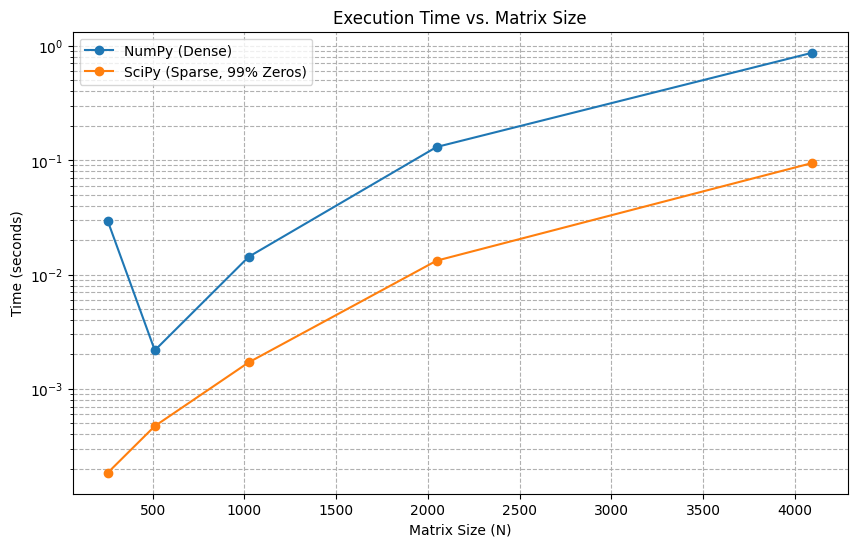

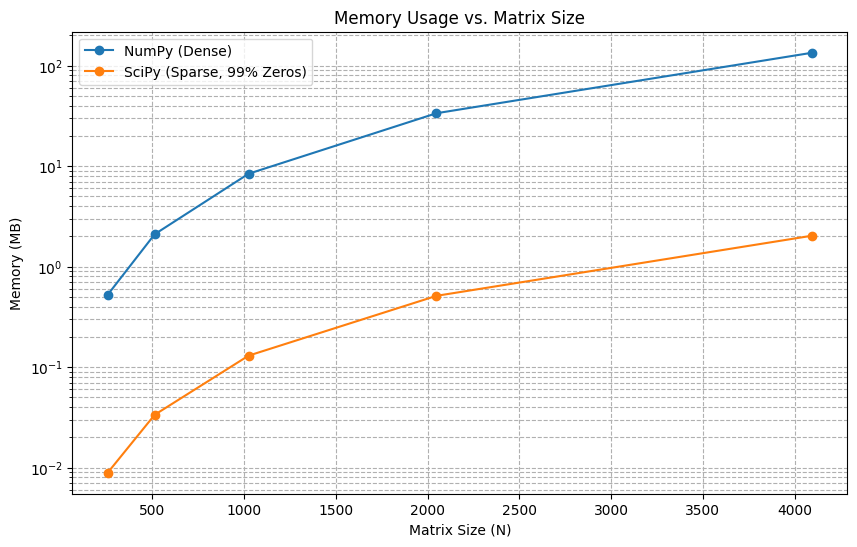

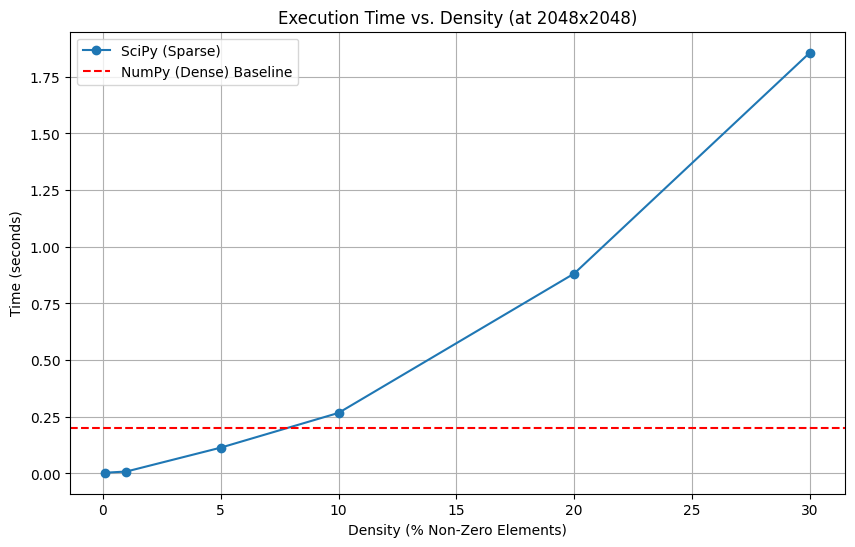

In [ ]:
print("\n--- Generating Plots ---")

plt.figure(figsize=(10, 6))
plt.plot(matrix_sizes, numpy_times, 'o-', label='NumPy (Dense)')
plt.plot(matrix_sizes, scipy_times, 'o-', label='SciPy (Sparse, 99% Zeros)')
plt.title('Execution Time vs. Matrix Size')
plt.xlabel('Matrix Size (N)')
plt.ylabel('Time (seconds)')
plt.yscale('log')
plt.legend()
plt.grid(True, which="both", ls="--")

plt.figure(figsize=(10, 6))
plt.plot(matrix_sizes, [m / 1e6 if m else None for m in numpy_memory], 'o-', label='NumPy (Dense)')
plt.plot(matrix_sizes, [m / 1e6 for m in scipy_memory], 'o-', label='SciPy (Sparse, 99% Zeros)')
plt.title('Memory Usage vs. Matrix Size')
plt.xlabel('Matrix Size (N)')
plt.ylabel('Memory (MB)')
plt.yscale('log')
plt.legend()
plt.grid(True, which="both", ls="--")

plt.figure(figsize=(10, 6))
plt.plot([d * 100 for d in density_levels], scipy_sparsity_times, 'o-', label='SciPy (Sparse)')
plt.axhline(y=numpy_baseline_time, color='r', linestyle='--', label=f'NumPy (Dense) Baseline')
plt.title(f'Execution Time vs. Density (at {sparsity_test_size}x{sparsity_test_size})')
plt.xlabel('Density (% Non-Zero Elements)')
plt.ylabel('Time (seconds)')
plt.legend()
plt.grid(True)

plt.show()
